# Analyze A/B Test Results 

This project consists of the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. In this project, I am working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(42)

### The Description of the Data
There are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Number of rows, columns
df.shape

(294478, 5)

In [4]:
rows_count = df.shape[0]
rows_count

294478

In [5]:
# Number of unique users in the dataset
df.user_id.nunique()

290584

In [6]:
# The proportion of users converted
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

In [7]:
#  The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].user_id.nunique()

# Using .query:
# df.query('group == "treatment" & landing_page != "new_page"').user_id.nunique()

1965

In [8]:
# The number of times the "group" and "landing_page" did not match
not_matching = df.query('(group == "treatment" & landing_page != "new_page") or (group == "control" & landing_page != "old_page")').user_id.nunique()
not_matching

3893

In [9]:
# Do any of the rows have missing values?
df.isnull().values.any() # check if there are missing values in the dataframe

False

In [10]:
# Count the number of missing values in each column
df.isnull().sum()  

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [12]:
#You can also check whether or not there is missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.

In [13]:
#check the percent of the missing rows to decide the best way to handle them:
not_matching/rows_count

#Since the ratio is very small, the best thing is to remove the rows.

0.013220002852505111

In [14]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df.query('(group == "treatment" & landing_page != "new_page") or (group == "control" & landing_page != "old_page")').index)

In [15]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
# The number of unique users 
df2.user_id.nunique()

290584

In [17]:
# check the number of rows of df2
df2.shape[0]

290585

In [18]:
# There is one user that is repeated
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
# The rows for the duplicate user
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [20]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

df2 = df2.drop(2893)

# Check again if the row with a duplicate user_id is deleted or not

df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [21]:
# The probability of an individual converting regardless of the page they receive
p_population = df2.query('converted == 1').shape[0] / df2.shape[0]
p_population

0.11959708724499628

In [22]:
# The probability of an individual from the 'control' group converting (conversion rate)
p_control = df2.query('converted == 1 & group == "control"').shape[0] / df2.query('group == "control"').shape[0]
p_control

0.1203863045004612

In [23]:
# The probability of an individual from the 'treatment' group converting (conversion rate)
p_treatment = df2.query('converted == 1 & group == "treatment"').shape[0] / df2.query('group == "treatment"').shape[0]
p_treatment

0.11880806551510564

In [24]:
# The actual difference (obs_diff) between the conversion rates for the two groups
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

In [25]:
# The probability that an individual received the new page
df.query('landing_page == "new_page"').shape[0] / df.shape[0]

0.5

>**Note: <br><br>The conversion rates of both groups were very close, with slightly higher rate for the control group (receiving the old_page). This does not suggest an improvement of the conversion with the new page. Sampling distribution is going to be carried out to check that this did not happen only by chance**

<a id='ab_test'></a>
## Part II - A/B Test

> **$H_0$** : **$p_{new}$** - **$p_{old}$** <= 0      <br><br>
    **$H_1$** :   **$p_{new}$** - **$p_{old}$**  > 0

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate.

In [26]:
# Based on the above assumption, p_new under the null hypothesis is the same as p_population
# p_population = df2.query('converted == 1').shape[0] / df2.shape[0]
p_new = p_population
p_new

0.11959708724499628

In [27]:
# # Based on the above assumption, p_old under the null hypothesis is the same as p_population
# p_population = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old = p_population
p_old

0.11959708724499628

In [28]:
# The number of individuals in each group
df2.group.value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

In [29]:
# The number of individuals in the 'treatment' group
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

In [30]:
# The number of individuals in the 'control' group
n_old = df2.query('group == "control"').shape[0]
n_old

145274

In [31]:
# Simulate a Sample for the treatment Group

new_page_converted = np.random.choice([0, 1], p=(1-p_new, p_new), size=n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
# Simulate a Sample for the control Group

old_page_converted = np.random.choice([0, 1], p=(1-p_old, p_old), size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
# The difference between the 'converted' probaiity for the simulated samples
new_page_converted.mean() - old_page_converted.mean()

0.0010303940409485124

In [34]:
# Sampling distribution of the difference between the 'converted' probability, 10,000 times:

p_diffs = []

#Using random.binomial to make the execution fast due to victorization
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation


# #Using a for loop is possible but it is slow:
# for _ in range(10000):
#     sample_new = np.random.choice([0, 1], p=(1-p_new, p_new), size=n_new)
#     sample_old = np.random.choice([0, 1], p=(1-p_old, p_old), size=n_old)
#     sam_p_new = sample_new.mean()
#     sam_p_old = sample_old.mean()
#     diff = sam_p_new - sam_p_old
#     p_diffs.append(diff)

    
## WARNING: Do not do the following:

## If you sample from the original sample, the code will take so long! I reduced the number of times to 1000
## and it still takes so long!
# for _ in range(1000):
#     new_page_sample = df2.sample(n_new)
#     old_page_sample = df2.sample(n_old)
#     new_sample = new_page_sample.query('group == "treatment" & converted == 1').shape[0] / new_page_sample.query('group == "treatment"').shape[0]
#     old_sample = old_page_sample.query('group == "control" & converted == 1').shape[0] / old_page_sample.query('group == "control"').shape[0]
#     diff = new_sample - old_sample
#     p_diffs.append(diff)

In [35]:
# Convert p_diffs to a numpy array
p_diffs = np.array(p_diffs)

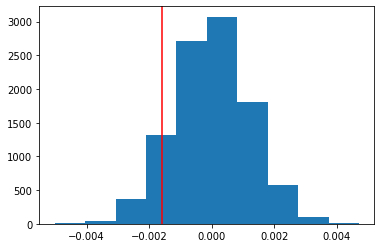

In [36]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='r')

0.9081

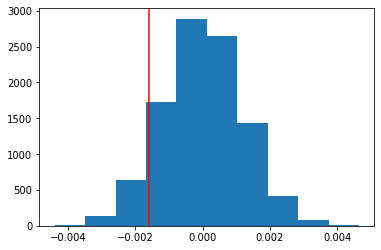

In [37]:
# The proportion of the p_diffs are greater than the actual difference observed in the `df2` data:

# Create a distribution following the null hypothesis (centred around 0), with the p_diffs standard deviation
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.hist(null_vals)
plt.axvline(obs_diff, color='r')

# p-value:
p_value = (null_vals > obs_diff).mean()
p_value

#### 1. The p-value is the probability of observing our statistic or a more extreme statistic under the null hypothesis. In this case, it is the probability of having the actual observed difference between the means of the conversion rates (new to old) happening under the null hypothesis. <br><br> 2. The big value signifies that the actual observed difference came from the null, and we fail to reject the null hypothesis. <br><br> This is also evident on the value being much greater than alpha (type I error rate): <br><br> p-value (0.9081) > alpha (0.05).

### Using Built-in Methods for Hypothesis Testing<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [38]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('converted == 1 & group == "control"').shape[0]

# number of conversions with the new_page
convert_new = df2.query('converted == 1 & group == "treatment"').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

I will use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
I have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [39]:
import statsmodels.api as sm

# Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


>**Since: <br><br> $Z_{score}$ = -1.3109 and $Z_{\alpha}$ = 1.645 (one-tailed tests) <br><br> $Z_{score}$ < $Z_{\alpha}$ <br><br> We fail to reject the null hypothesis. <br><br> Also p-value is large and is much greater than the alpha value, so we fail to reject the null hypothesis. <br><br> This means that the conversion rate of the old page is greater than the new page, and the result agrees with the sampling distribution.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since the response of this regression model is a categorical variable of two choices; conversion or no conversion, a Logistic Regression model is what suits the problem.

In [40]:
df2['intercept'] = 1

In [41]:
# `ab_page` is a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`
df2[['ab_page_to_drop', 'ab_page']] = pd.get_dummies(df['group'])
df2 = df2.drop('ab_page_to_drop', axis=1)
df2

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0


In [42]:
# Fitting a Logistic Regression model
logistic_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logistic_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [43]:
# A summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:               8.077e-06
Time:                        02:16:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

### Remarks:
>**1. In regression, p-value is given for testing that the parameter (slope) is equal to zero in the null hypothesis or differs than zero in the alternative hypothesis.<br><br>2. So unlike sampling distribution and hypothesis testing (Part II), smaller p-value supports the alternative (where the slope is not zero). And therefore, smaller p-value suggests that the variable is statistically significant for predicting the reponse.<br><br>3. In this model, the intercept is statistically significant and the page design is not as much significant. This is weakness in the model, that could be due to missing other variables from the model.<br><br>4. The main reason why the p-value differs than that from Part II is the type of test. As can be seen from the forumlated hypotheses in Part II, we had one-tailed test, whereas in Part III a two tailed test.<br><br>5. Interpreting the regression model coefficient shows that the user receving the old page is going to convert more than the one receiving the new page, as shown in the next line of code:**

In [44]:
1 / np.exp(-0.0150)

1.015113064615719

>**Interpreting the regression model coefficient reconfirms that a user receives the old page, they are 1.015 times as likely to convert than if they receive the new page.**

### Question:<br><br>Is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**The timestamp can be added as a variable to see if the browsing time has an effect on the user choice of conversion. The timestamp can be converted to a categorical variable. <br><br> Typical difficulties arise from adding more variables are to 1. making sure that the variables are independent and 2. more difficulty in interpreting the coefficients.<br><br>However, I see that those two difficulties are not sound in this case.<br><br>There could be more data collected in the future, shall a new experiment is to be designed, such as new vs old user category. This will take in account the reluctance to change.**

In [45]:
# Adding the country each user lives in
df_countries = pd.read_csv('countries.csv')
df_countries

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK
...,...,...
290579,653118,US
290580,878226,UK
290581,799368,UK
290582,655535,CA


In [46]:
# Join with the df2 dataframe
df_merged = df2.merge(df_countries, on='user_id', how='left')
df_merged

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US


In [47]:
# checking the number of users in each country:
df_merged['country'].value_counts() 

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [48]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US,0,0,1
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US,0,0,1
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US,0,0,1
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US,0,0,1


In [49]:
# Fit the model, and summarize the results
log_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:               2.323e-05
Time:                        02:17:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [50]:
# Take the exponential value of the coefficients
np.exp(results2.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [51]:
# Take the reciprocal of the page coefficient (since it is less than 1)
1/np.exp(-0.0149)

1.0150115583846535

>**The coefficients and p-values of this model show:<br><br>1. The effects of the all the variables (country and page design) are not statistically significant, as shown in both the p-values (not very small) and the coefficients (very small).<br><br> 2. Users receiving the old page are 1.015 times as likely to convert than the one receiving the new page, if they are from the country.<br><br> 3. Users from the UK are 1.05 times as likely to convert than those from Canada, if they receive the same page.<br><br> 4. Users from the US are 1.04 times as likely to convert than those from Canada, if they receive the same page.**

### I have looked at the individual factors of country and page on conversion. I will look at an interaction between page and country to see if are there significant effects on conversion. 

In [52]:
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']

final_log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'ab_UK', 'ab_US']])
final_results = final_log_mod.fit()
final_results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:               3.482e-05
Time:                        02:17:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [53]:
# Take the exponential value of the coefficients
np.exp(final_results.params)

intercept    0.134794
ab_page      0.934776
UK           1.011854
US           1.017682
ab_UK        1.081428
ab_US        1.048001
dtype: float64

In [54]:
# Take the reciprocal of the page coefficient (since it is less than 1)
1/np.exp(-0.0674)

1.0697232819209153

#### Conculsions based on the last two tests: <br><br> 1. The effects of the all the variables (page design, country and page-country interaction) are not statistically significant, as shown in both the p-values (not very small) and the coefficients (very small).<br><br> 2. The intercept remains to be statistically significant for the conversion rate.<br><br> 3. Users receiving the old page are 1.07 times as likely to convert than the one receiving the new page, if they are from the same country.<br><br> 4. Users from the UK are 1.012 times as likely to convert than those from Canada, if they receive the same page.<br><br> 5. Users from the US are 1.018 times as likely to convert than those from Canada, if they receive the same page.<br><br> 6. Users from the UK receiving the new page are 1.081 times as likely to convert than those from Canada, if they receive the same page.<br><br> 7. Users from the US receiving the new page are 1.048 times as likely to convert than those from Canada, if they receive the same page.<br><br> 8. Although the statistical evidence suggests that users are likely to convert more when shown the old page, the difference in the conversion rate and in interpreting the regression model coefficients are insignificant, from a practical point of view.<br><br> 9. The experiment is run on a big sample of users (290,584), who were divided nearly equal between the control group and the treatment group. Both groups of the sample had nearly the same conversion rates. Despite being small, there is a statistical increase in the conversion rate with the old page. Therefore, I recommend keeping the old page.<br><br> 10. I recommend to the company to explore other marketing channels or other page design, if they find such suggestion worthy, business wise.